In [112]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

import IPython
import import_ipynb
from pca import *
from prepare_data import *
from plot_figures import *
from NNpythorch import *

from sklearn.model_selection import GridSearchCV
%matplotlib inline
import warnings
warnings.simplefilter("ignore")


**Input Data**
* Data stored in a csv file are stored in a dataframe

In [113]:
cars_original = pd.read_csv(r'C:\Users\margh\OneDrive\Documenti\GIT\Marketing_Analytics\car_data.csv')
cars_original.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### **Exploratory Data Analysis**
* The analysis report presents that the DataFrame has 11914 rows and each row represents one car. The DataFrame has 16 features, 8 of which are catergorical. Engine Fuel Type, Engine HP, Engine Cylinders, Number of Doors, Market Category present missing values.

In [114]:
#@ Exploratory Data Analysis:
cars_original.info()                  # Inspecting the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

**Market category**
* This column includes a list of elements
* it is transformed in severla columns, one for each element

In [115]:
mc = cars_original['Market Category'].str.get_dummies(',')
c_0 =cars_original.drop('Market Category', axis = 1)
cars = pd.concat([c_0, mc], axis=1)
cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Number of Doors**
* There is clearly a different definition for the number of doors, so I changed 3 to 2 for coherence

In [116]:
cars[cars['Number of Doors'] == 3]['Number of Doors']=2

### **Fill Nan**
* Engine Fuel Type: only 3 are missing, so I fill with the average value of the same make and model, which is constant
* Missing vlues for electric cars are averaged over electric cars only
* Flex fuel with gas is the average of the same mKE/MODEL/YEAR

In [117]:

fill_mode = lambda g:g.fillna(g.value_counts().idxmax()[0])
cars[['Engine Fuel Type']] = cars[['Engine Fuel Type']].groupby([cars['Make'],cars['Model']]).apply(fill_mode)

fill_mean = lambda g: g.fillna(round(g.mean()))
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model']]).apply(fill_mean)

cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11914 non-null  object 
 4   Engine HP          11914 non-null  float64
 5   Engine Cylinders   11914 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11914 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Outliers**
* I checked the outliers are removed a sample with a mistype ( I could have fiyed but I did not see the point)
* Very eypensive cars look consistents in terms of makes

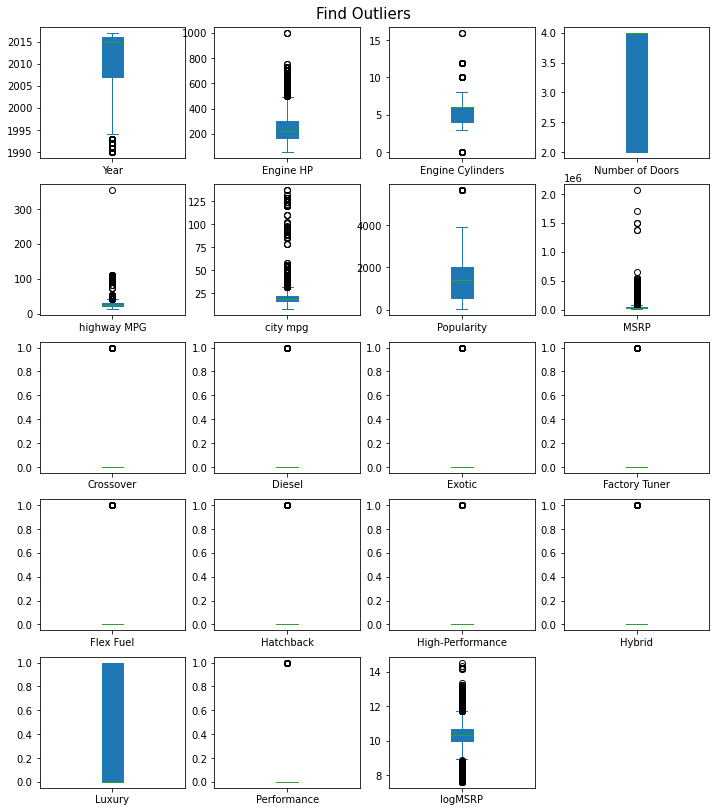

In [118]:
# See if there is any outliers

# select columns to plot

cars['logMSRP']= np.log(cars.MSRP)
df_to_plot = cars#.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)
# subplots
df_to_plot.plot(subplots=True, layout=(5,4), kind='box', figsize=(12,14), patch_artist=True)
plt.suptitle('Find Outliers', fontsize=15, y=0.9)
plt.savefig('boxplots.png', bbox_inches='tight')

In [119]:
expensive_cars = cars[cars['MSRP']>1000000]

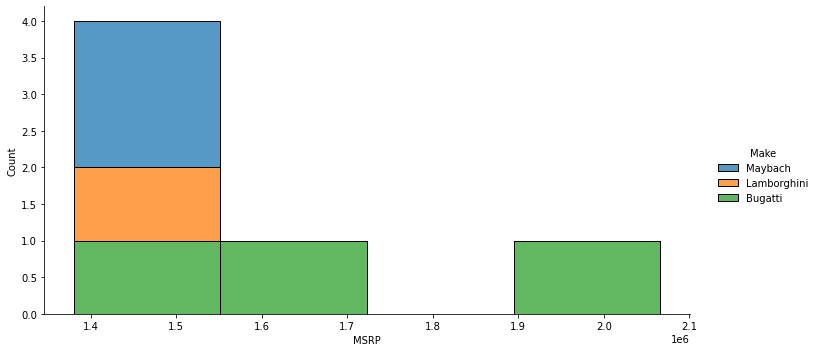

In [120]:

import seaborn as sns

ax=sns.displot(expensive_cars, x= 'MSRP', hue ='Make',common_norm=False, kind="hist", multiple="stack", height=5, aspect=2)


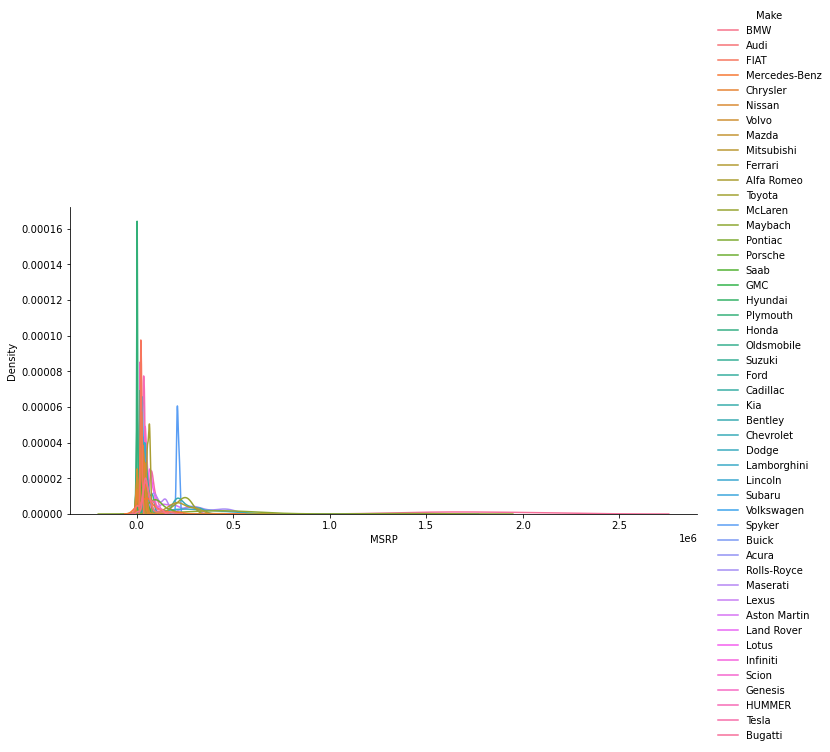

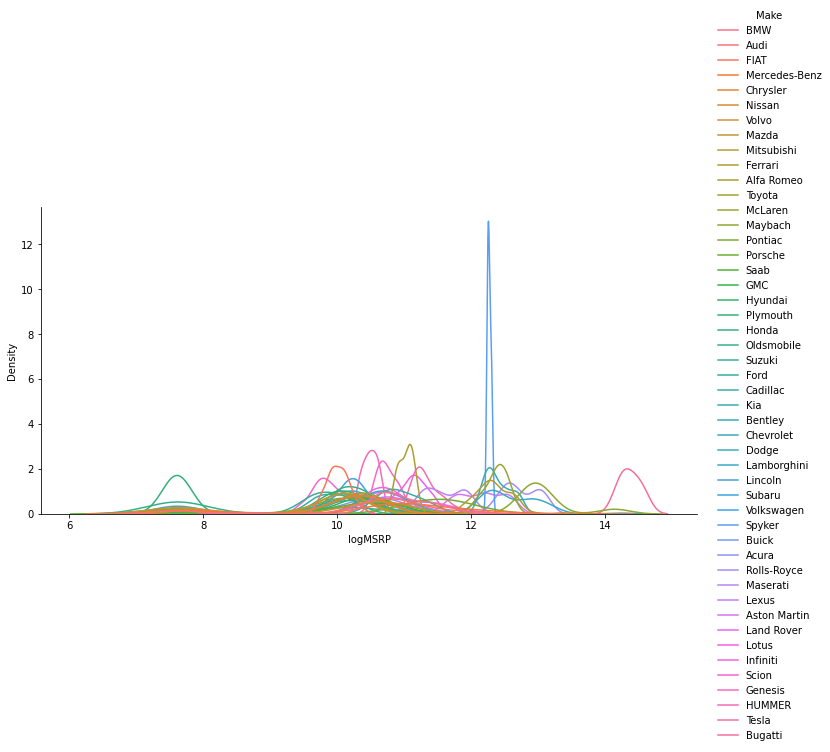

In [121]:

ax=sns.displot(cars, x= 'MSRP', hue ='Make',common_norm=False, kind="kde", height=5, aspect=2)
ax1=sns.displot(cars, x= 'logMSRP', hue ='Make',common_norm=False, kind="kde", height=5, aspect=2)

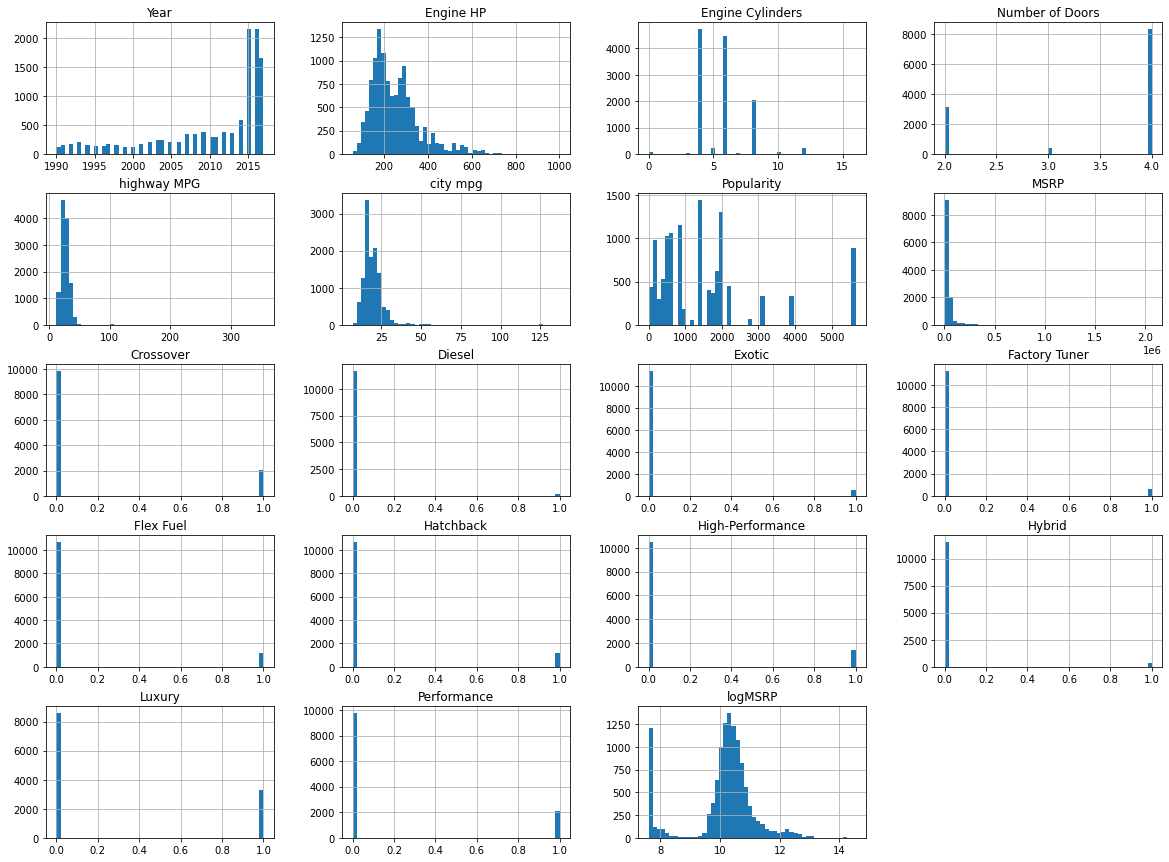

In [122]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt
cars.hist(bins=50, figsize=(20, 15))   
plt.show()

In [123]:
makes =set(cars['Make'])
models = set(cars['Model'])


y = cars[['MSRP']]
ys = cars[['MSRP','logMSRP']]
logy = cars[['logMSRP']]
X = cars.drop(columns=['MSRP','logMSRP'])


### **Split**
* Random split between test / val / train. We split randomly each make as we want in the training / val/test elements of each make

In [124]:
for i,model in enumerate(models):
    X_tmp = X[cars.Model == model]
    y_tmp = ys[cars.Model == model]
    if X_tmp.shape[0] == 1:
        X_train_tmp = X_tmp
        X_test_tmp = []
        X_val_tmp = []
        y_train_tmp = y_tmp
        y_test_tmp = []
        y_val_tmp = []
    elif X_tmp.shape[0] == 2:
        X_train_tmp = X_tmp[0]
        X_test_tmp = X_tmp[1]
        X_val_tmp = []
        y_train_tmp = y_tmp[0]
        y_test_tmp = y_tmp[1]
        y_val_tmp = []
    elif X_tmp.shape[0] == 4:
        X_train_tmp = X_tmp[0]
        X_test_tmp = X_tmp[1]
        X_val_tmp = X_tmp[2]
        y_train_tmp = y_tmp[0]
        y_test_tmp = y_tmp[1]
        y_val_tmp = y_tmp[2]
    elif:
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=1)
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, y_train_tmp, test_size=0.25, random_state=1)
    if i==0:
        X_train = X_train_tmp
        X_test = X_test_tmp
        X_val = X_val_tmp
    else:
        X_train = pd.concat([X_train, X_train_tmp], axis=0)
        X_test = pd.concat([X_test, X_test_tmp], axis=0)
        X_val = pd.concat([X_val, X_val_tmp], axis=0)

    if i==0:
        ys_train = y_train_tmp
        ys_test = y_test_tmp
        ys_val = y_val_tmp
    else:
        ys_train = pd.concat([ys_train, y_train_tmp], axis=0)
        ys_test = pd.concat([ys_test, y_test_tmp], axis=0)
        ys_val = pd.concat([ys_val, y_val_tmp], axis=0)

ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
def prepare_data_for_training( index_list,index_list_val,X_train,X_val,X_test,y_train):

    train_col=pd.get_dummies(X_train[index_list].drop(columns=['Make'])).columns
    test_col=pd.get_dummies(X_test[index_list_val].drop(columns=['Make'])).columns
    val_col=pd.get_dummies(X_val[index_list_val].drop(columns=['Make'])).columns

    cols = list(set(np.concatenate((train_col,test_col,val_col))))
    X_train_tmp =  pd.get_dummies(X_train[index_list])
    X_val_tmp =  pd.get_dummies(X_val[index_list_val])
    X_test_tmp =  pd.get_dummies(X_test[index_list_val])
    
    for col in cols:
        if (not (col in X_train_tmp.columns)):
            X_train_tmp[col] = 0
        if (not (col in X_val_tmp.columns)):
            X_val_tmp[col] = 0
        if (not (col in X_test_tmp.columns)):
            X_test_tmp[col] = 0
   
    y_train_tmp = y_train[index_list]
    X_train_tmp =  X_train_tmp[cols]
    X_val_tmp =  X_val_tmp[cols]
    X_test_tmp =  X_val_tmp[cols]

    return [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp]

In [ ]:
def training(rg, index_list,index_list_val,X_train,X_val,X_test,y_train):

    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp] = prepare_data_for_training( index_list,index_list_val,X_train,X_val,X_test,y_train)

    if len(X_train_tmp)>0:
        rg.fit(X_train_tmp, y_train_tmp)
        y_train_pred_tmp=rg.predict(X_train_tmp)
        if len(X_val_tmp)>0:
            y_pred_tmp=rg.predict(X_val_tmp)
        else:
            y_pred_tmp=[]
    else:
        y_pred_tmp=[]
        y_train_pred_tmp=[]

    return [y_pred_tmp,y_train_pred_tmp]

In [ ]:
def plot_result_1(y_val, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))


    fig1, ax = plt.subplots(1,1)
    ax.scatter(np.ravel (y_val), np.ravel (y_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_title('Validation - recorded vs predicted ')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')

    """""
    fig2, ax = plt.subplots(1,1)
    ax.scatter(np.ravel (y_val), np.ravel (y_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_title('Validation - recorded vs predicted ')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')
    ax.set_xlim([0, 500000])
    ax.set_ylim([0, 500000])
    plt.show() 
     """


    fig3, ax = plt.subplots(1,1)
    ax.scatter(np.ravel (y_val), np.ravel (y_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_title('Validation - recorded vs predicted ')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')
    ax.set_xlim([0, 50000])
    ax.set_ylim([0, 50000])
    plt.show() 
   
    return

In [ ]:
ylog = False
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]
    


In [ ]:
model10 = []
for i,model in enumerate(models):
    if ((cars.Model == models).shape[0])>9:
        model10.append(model)

In [ ]:
model10 = []
model_make={}
for i,make in enumerate(makes):
    cars_make = cars[cars.Make == make]
    mods= []
    for i,model in enumerate(models):
        if ((cars_make.Model == model).shape[0])>0:
            mods.append(model)
    model_make[make] = mods

In [ ]:
regressor = RandomForestRegressor()
random_grid = {'max_depth': [2,5,10,20]             }

# Fit the random search model

regressors={}
for i,make in enumerate(makes):    
    cars_make = cars[cars.Make == make]
    for i,model in enumerate(model_make[make]):
        
        index_list_val = pd.Series([True if (cars.Make[i] == make and cars.Model[i] == model) else False for i in range(cars.shape[0])])
        if ((cars_make.Model == model).shape[0])>9:            
            index_list =index_list_val
        else:
            index_list = (cars.Make == make )

        print('cars.shape[0]',cars.shape[0])
        print('index_list',len(index_list))
        print('index_list_val',len(index_list_val))

        #rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
        [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp] = prepare_data_for_training( index_list,index_list_val,X_train,X_val,X_test,y_train)
        if X_train_tmp.shape[0]>5:
            regressor_grid_search = GridSearchCV(regressor, random_grid, 
            scoring = 'neg_mean_squared_error', return_train_score = True,cv = min(5,  X_train_tmp.shape[0]), verbose = 0, n_jobs = -1)

            regressor_grid_search.fit(X_train_tmp, y_train_tmp)
            regressors [make] = regressor_grid_search.best_estimator_
        else:
            rg = RandomForestRegressor(n_estimators=200,max_depth=10, n_jobs=-1)
            rg.fit(X_train_tmp, y_train_tmp)
            regressors [make] = rg

        y_pred_tmp = regressors [make].predict(X_val_tmp)    
        y_train_pred_tmp = regressors [make].predict(X_train_tmp)    
        
        
        if i==0:
            y_pred = y_pred_tmp            
            y_train_pred = y_train_pred_tmp
        else:
            y_pred = np.concatenate((y_pred, y_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            
plot_result_1(y_val, y_pred)
plot_result_1(y_train, y_train_pred)

cars.shape[0] 11914
index_list 11914
index_list_val 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914


ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
regressor = RandomForestRegressor()
random_grid = {'max_depth': [2,5,10,20]             }

# Fit the random search model

regressors={}
for i,make in enumerate(makes):

        index_list = cars.Make == make
        
        print('cars.shape[0]',cars.shape[0])
        print('index_list',len(index_list))
        #rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
        [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp] = prepare_data_for_training( index_list,index_list,X_train,X_val,X_test,y_train)
        if X_train_tmp.shape[0]>5:
            regressor_grid_search = GridSearchCV(regressor, random_grid, 
            scoring = 'neg_mean_squared_error', return_train_score = True,cv = min(5,  X_train_tmp.shape[0]), verbose = 0, n_jobs = -1)

            regressor_grid_search.fit(X_train_tmp, y_train_tmp)
            regressors [make] = regressor_grid_search.best_estimator_
        else:
            rg = RandomForestRegressor(n_estimators=200,max_depth=10, n_jobs=-1)
            rg.fit(X_train_tmp, y_train_tmp)
            regressors [make] = rg

        y_pred_tmp = regressors [make].predict(X_val_tmp)    
        y_train_pred_tmp = regressors [make].predict(X_train_tmp)    
        
        
        if i==0:
            y_pred = y_pred_tmp            
            y_train_pred = y_train_pred_tmp
        else:
            y_pred = np.concatenate((y_pred, y_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            
plot_result_1(y_val, y_pred)
plot_result_1(y_train, y_train_pred)

    

cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list 11914
X_train.shape[0] 7117
X_test.shape[0] 2405
index_list 11914
cars.shape[0] 11914
index_list

KeyboardInterrupt: 

In [ ]:

rg_list = []
rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=10, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=20, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=200, n_jobs=-1))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(10,10,10),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(10,10,10,10,10,10),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(20,20,20),max_iter=100))

regressors={}
for j ,rg in enumerate (rg_list):
    print (j)
    for i,make in enumerate(makes):

        index_list = cars.Make == make
        #rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
        index_list_val = index_list
        [y_pred_tmp,y_train_pred_tmp] = training(rg = rg, index_list=index_list,index_list_val=index_list_val,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)
        
        regressors [make] =rg
        
        if i==0:
            y_pred = y_pred_tmp            
            y_train_pred = y_train_pred_tmp
        else:
            y_pred = np.concatenate((y_pred, y_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            
    plot_result_1(y_val, y_pred)
    plot_result_1(y_train, y_train_pred)


0


TypeError: training() got an unexpected keyword argument 'index_list_model'

0
Mean Absolute Error: 10164.918179239558
Mean Squared Error: 611024450.772457
Root Mean Squared Error: 24718.90876985586
Mean Absolute Error: 10660.885643507938
Mean Squared Error: 719013216.1287429
Root Mean Squared Error: 26814.4217936681
1
Mean Absolute Error: 10264.660225678123
Mean Squared Error: 607099346.8855255
Root Mean Squared Error: 24639.38608986688
Mean Absolute Error: 10948.015458990807
Mean Squared Error: 748003910.1355071
Root Mean Squared Error: 27349.66014661804
2
Mean Absolute Error: 10551.985210832318
Mean Squared Error: 610976545.2517588
Root Mean Squared Error: 24717.93974528943
Mean Absolute Error: 11157.592626107004
Mean Squared Error: 756208172.3958057
Root Mean Squared Error: 27499.239487589573


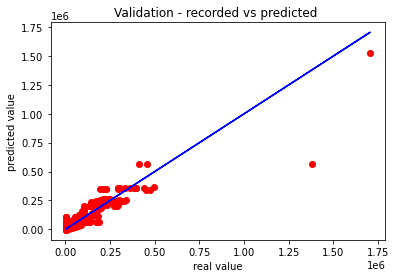

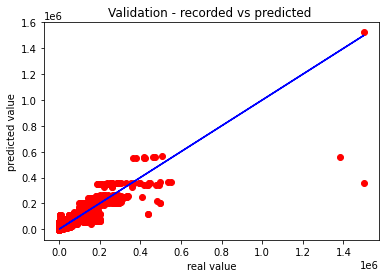

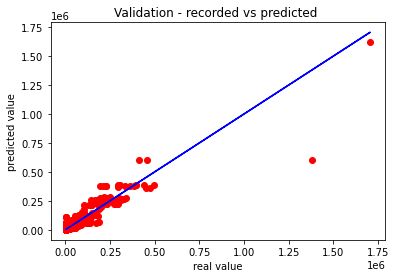

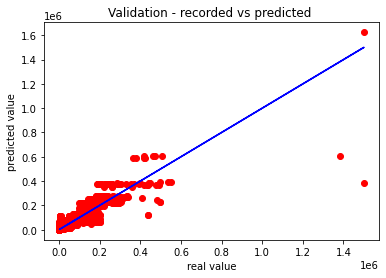

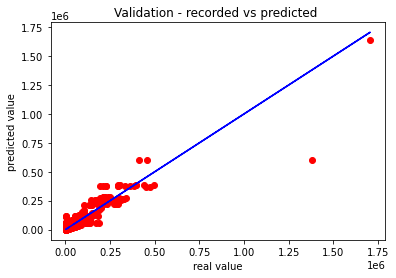

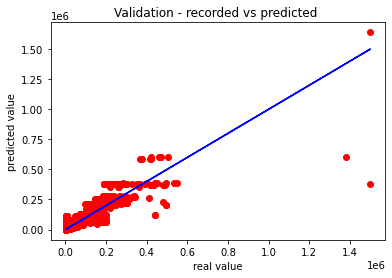

In [ ]:

rg_list = []

#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=200, n_jobs=-1))
rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000))
rg_list.append( MLPRegressor(hidden_layer_sizes=(164,164,164),activation="relu" ,random_state=1, max_iter=2000))
rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64,64),activation="relu" ,random_state=1, max_iter=2000))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(100),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(100,100),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(500),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(10,10,10,10,10,10),max_iter=100))
#rg_list.append( MLPRegressor(random_state=1, hidden_layer_sizes=(20,20,20),max_iter=100))

regressors={}
for j ,rg in enumerate (rg_list):
    print (j)
    for i,make in enumerate(makes):

        index_list = cars.Make == make
        #rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
        
        [y_pred_tmp,y_train_pred_tmp] = training(rg = rg, index_list=index_list,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)
        
        regressors [make] =rg
        
        if i==0:
            y_pred = y_pred_tmp            
            y_train_pred = y_train_pred_tmp
        else:
            y_pred = np.concatenate((y_pred, y_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            
    plot_result_1(y_val, y_pred)
    plot_result_1(y_train, y_train_pred)

In [ ]:
for i,model in enumerate(models):

    index_list = cars.Model == model
    index_list_val = index_list 
    if len(index_list)>0:
        rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
        
        y_pred_tmp = training(rg = rg, index_list=index_list,index_list_val=index_list_val,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)

        if i==0:
            y_pred = y_pred_tmp
        else:
            y_pred = np.concatenate((y_pred, y_pred_tmp))
        
plot_result_1(y_val, y_pred)


ValueError: Found input variables with inconsistent numbers of samples: [2392, 2363]

In [ ]:
import torch
import torch.nn as nn
import torchvision

import torch.optim as optim

In [ ]:
class Net_3_layers1(nn.Module):
    def __init__(self, M):
        super(Net_3_layers, self).__init__()
        
        self.fc1 = nn.Linear(M, 20)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
       
        return x

In [ ]:
class Net_3_layers(nn.Module):
    def __init__(self, M):
        super(Net_3_layers, self).__init__()
        
        self.fc1 = nn.Linear(M, 15)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(15, 10)
        self.fc3 = nn.Linear(10, 4)
        self.fc4 = nn.Linear(4, 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
       
        return x

In [ ]:
def create_input_for_NN(X,y, lr =1e-3 ):
    
    
    net = Net_3_layers(M=X.shape[1])
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    


    X_tensor = torch.tensor(X.values, dtype=torch.float)
    y_tensor = torch.tensor(y.values, dtype=torch.float)

    assert X.shape[0] ==X_tensor.shape[0] , 'wrong input_df_vec dimensions'
    assert y.shape[0] ==y_tensor.shape[0] , 'wrong input_df_vec dimensions'
    assert len(X.columns) ==X_tensor.shape[1] , 'wrong input_df_vec dimensions'

    train_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3000, shuffle=True, num_workers=0)

    

    return [net, optimizer, criterion,X_tensor, y_tensor,train_dataset,train_loader]
   

In [ ]:

def training_NN(net='', optimizer = '', criterion='',train_loader='', niter = 200):

    loss_vec=[]
    for epoch in range(niter):  # loop over the dataset multiple times

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(torch.flatten(outputs), torch.flatten(labels))
            loss.backward()
            optimizer.step()

            loss_vec.append(loss.detach().numpy())


    return 

Mean Absolute Error: 19347.978468139834
Mean Squared Error: 1722237857.9890087
Root Mean Squared Error: 41499.853710453106


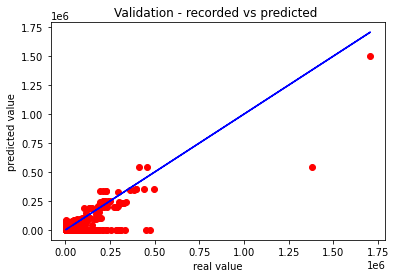

In [ ]:

for i,make in enumerate(makes):


    index_list = cars.Make == make

    train_col=pd.get_dummies(X_train[index_list].drop(columns=['Make'])).columns
    test_col=pd.get_dummies(X_test[index_list].drop(columns=['Make'])).columns
    val_col=pd.get_dummies(X_val[index_list].drop(columns=['Make'])).columns

    cols = list(set(np.concatenate((train_col,test_col,val_col))))
    X_train_tmp =  pd.get_dummies(X_train[index_list])
    X_val_tmp =  pd.get_dummies(X_val[index_list])
    
    for col in cols:
        if (not (col in X_train_tmp.columns)):
            X_train_tmp[col] = 0
        if (not (col in X_val_tmp.columns)):
            X_val_tmp[col] = 0
   
    y_train_tmp = y_train[index_list]
    X_train_tmp =  X_train_tmp[cols]
    X_val_tmp =  X_val_tmp[cols]

    X_test_tensor = torch.tensor(X_val_tmp.values, dtype=torch.float)
    y_test_tensor = torch.tensor(np.ravel(y_val.values), dtype=torch.float)
    #y_test_long = torch.tensor(np.ravel(y_test.values), dtype=torch.long)
    
    [net, optimizer, criterion, X_train_tensor, y_train_tensor,train_dataset,train_loader] = create_input_for_NN(
        X_train_tmp,y_train_tmp)
    training_NN(net=net, optimizer = optimizer, criterion=criterion,train_loader=train_loader, niter = 2000)
    
    y_pred_tmp =  net(X_test_tensor)

    if i==0:
        y_pred = y_pred_tmp.detach().numpy()
    else:
        y_pred = np.concatenate((y_pred, y_pred_tmp.detach().numpy()))
plot_result_1(y_val, y_pred)

Mean Absolute Error: 24346.020306947637
Mean Squared Error: 3833818488.0372286
Root Mean Squared Error: 61917.83659041415


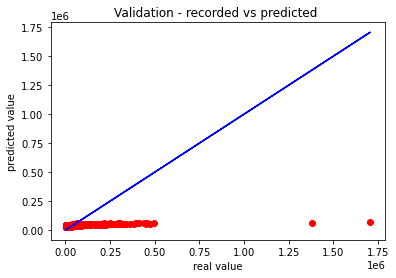

In [ ]:
index_list = cars.Make != np.NAN
train_col=pd.get_dummies(X_train[index_list].drop(columns=['Make'])).columns
test_col=pd.get_dummies(X_test[index_list].drop(columns=['Make'])).columns
val_col=pd.get_dummies(X_val[index_list].drop(columns=['Make'])).columns

cols = list(set(np.concatenate((train_col,test_col,val_col))))
X_train_tmp =  pd.get_dummies(X_train[index_list])
X_val_tmp =  pd.get_dummies(X_val[index_list])

for col in cols:
    if (not (col in X_train_tmp.columns)):
        X_train_tmp[col] = 0
    if (not (col in X_val_tmp.columns)):
        X_val_tmp[col] = 0

y_train_tmp = y_train[index_list]
X_train_tmp =  X_train_tmp[cols]
X_val_tmp =  X_val_tmp[cols]

#rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)

#y_pred_tmp = training(rg = rg, index_list=index_list,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)


X_test_tensor = torch.tensor(X_val_tmp.values, dtype=torch.float)
y_test_tensor = torch.tensor(np.ravel(y_val.values), dtype=torch.float)
#y_test_long = torch.tensor(np.ravel(y_test.values), dtype=torch.long)

[net, optimizer, criterion, X_train_tensor, y_train_tensor,train_dataset,train_loader] = create_input_for_NN(
    X_train_tmp,y_train_tmp)
training_NN(net=net, optimizer = optimizer, criterion=criterion,train_loader=train_loader, niter = 400)

y_pred =  net(X_test_tensor)
    
plot_result_1(y_val, y_pred.detach().numpy())


In [ ]:
"""
ylog = True
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]
    
for i,make in enumerate(makes):

    index_list = cars.Make == make
    rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
    
    y_pred_tmp = training(rg = rg, index_list=index_list,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)

    if i==0:
        y_pred = y_pred_tmp
    else:
        y_pred = np.concatenate((y_pred, y_pred_tmp))
        
plot_result_1(y_val, y_pred)
plot_result_1(np.exp(y_val), np.exp(y_pred))
"""

"\nylog = True\nif ylog:\n    y_train = ys_train[['logMSRP']]\n    y_val = ys_val[['logMSRP']]\n    y_test = ys_test[['logMSRP']]\nelse:\n    y_train = ys_train[['MSRP']]\n    y_val = ys_val[['MSRP']]\n    y_test = ys_test[['MSRP']]\n    \nfor i,make in enumerate(makes):\n\n    index_list = cars.Make == make\n    rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)\n    \n    y_pred_tmp = training(rg = rg, index_list=index_list,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)\n\n    if i==0:\n        y_pred = y_pred_tmp\n    else:\n        y_pred = np.concatenate((y_pred, y_pred_tmp))\n        \nplot_result_1(y_val, y_pred)\nplot_result_1(np.exp(y_val), np.exp(y_pred))\n"

In [ ]:
X_val['Predicted'] = y_pred
X_val['Recorded'] = y_val
X_val['Error'] = np.abs((np.ravel (y_val)- np.ravel (y_pred))/(np.ravel (y_val)+ 1))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
X_val[X_val['Error']>1].sort_values(by=['Error'], ascending=False)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,...,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error
4084,Lexus,ES 250,1990,regular unleaded,156.0,6.0,MANUAL,front wheel drive,4.0,Compact,...,0,0,0,0,0,1,0,66616.585938,2000,32.292147
6418,Acura,Legend,1993,regular unleaded,230.0,6.0,MANUAL,front wheel drive,2.0,Midsize,...,0,0,0,0,0,1,1,62401.730469,2000,30.185772
6416,Acura,Legend,1993,regular unleaded,230.0,6.0,MANUAL,front wheel drive,2.0,Midsize,...,0,0,0,0,0,1,1,62429.671875,2042,29.558332
6426,Acura,Legend,1995,regular unleaded,230.0,6.0,MANUAL,front wheel drive,2.0,Midsize,...,0,0,0,0,0,1,1,62619.507812,2265,26.634823
187,Mercedes-Benz,300-Class,1993,diesel,121.0,5.0,AUTOMATIC,rear wheel drive,4.0,Midsize,...,0,0,0,0,0,1,0,54305.605469,2000,26.139733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,Bentley,Continental GTC,2014,flex-fuel (premium unleaded required/E85),567.0,12.0,AUTOMATIC,all wheel drive,2.0,Midsize,...,0,1,0,1,0,1,0,-22.033676,218500,1.000096
2857,Bentley,Continental GT Speed,2014,flex-fuel (premium unleaded required/E85),616.0,12.0,AUTOMATIC,all wheel drive,2.0,Midsize,...,1,1,0,1,0,1,0,-21.184029,217000,1.000093
2876,Bentley,Continental GT,2016,premium unleaded (required),521.0,8.0,AUTOMATIC,all wheel drive,2.0,Midsize,...,1,0,0,1,0,1,0,-20.343561,210700,1.000092
2856,Bentley,Continental GT Speed,2010,premium unleaded (required),600.0,12.0,AUTOMATIC,all wheel drive,2.0,Midsize,...,1,0,0,1,0,1,0,-18.996149,207700,1.000087


In [ ]:
ind = [i  for i in range(len(y_val)) if np.abs((np.ravel (y_val)[i]- np.ravel (y_pred)[i])/(np.ravel (y_val)[i]+ 1))>0.5 ]
very_wrong = X_val.iloc[ind,:]
very_wrong.head()
#(np.ravel (y_val)[1]- np.ravel (y_pred)[1])/(np.ravel (y_val)[1]+ 1)>0.1

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,...,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error
1733,Mazda,B-Series Truck,2009,regular unleaded,207.0,6.0,MANUAL,four wheel drive,4.0,Compact,...,0,0,0,0,0,0,0,-195.250320,22150,1.008769
1715,Mazda,B-Series Pickup,2000,regular unleaded,160.0,6.0,MANUAL,four wheel drive,4.0,Compact,...,0,0,0,0,0,0,0,-77.637764,3768,1.020334
1746,Mazda,B-Series,2001,regular unleaded,150.0,6.0,MANUAL,rear wheel drive,2.0,Compact,...,0,0,0,0,0,0,0,-173.689850,15125,1.011417
3348,Mazda,CX-3,2017,regular unleaded,146.0,4.0,AUTOMATIC,all wheel drive,4.0,Compact,...,0,0,0,0,0,0,0,-185.043716,23210,1.007929
6750,Mazda,Mazdaspeed MX-5 Miata,2005,premium unleaded (required),178.0,4.0,MANUAL,rear wheel drive,2.0,Compact,...,1,0,0,0,0,0,1,-198.094894,26580,1.007415


Mean Absolute Error: 3479.216863263117
Mean Squared Error: 258913494.62285978
Root Mean Squared Error: 16090.789123683766


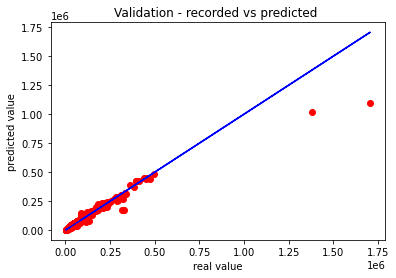

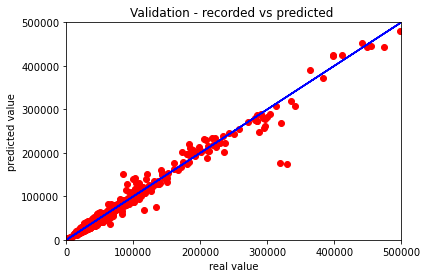

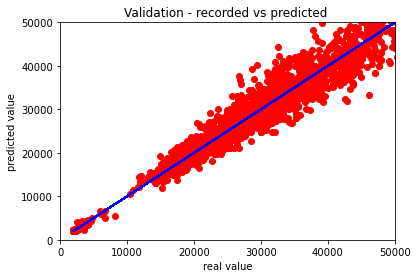

In [ ]:

rg_list = []
#Create a Random Forest Classifier with 100 trees
rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=200,  n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=500,  n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=1100,  n_jobs=-1))


for i ,rg in enumerate (rg_list):
    index_list = cars.Make != np.NAN
    rg = RandomForestRegressor(n_estimators=200,max_depth=50, n_jobs=-1)
    
    y_pred = training(rg = rg, index_list=index_list,X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train)
        
    plot_result_1(y_val, y_pred)


In [ ]:
ecars = cars[cars['Engine Fuel Type']=='electric']
fcars = cars[cars['Engine Fuel Type']!='electric']

ecars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 539 to 9872
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               66 non-null     object 
 1   Model              66 non-null     object 
 2   Year               66 non-null     int64  
 3   Engine Fuel Type   66 non-null     object 
 4   Engine HP          66 non-null     float64
 5   Engine Cylinders   66 non-null     float64
 6   Transmission Type  66 non-null     object 
 7   Driven_Wheels      66 non-null     object 
 8   Number of Doors    66 non-null     float64
 9   Vehicle Size       66 non-null     object 
 10  Vehicle Style      66 non-null     object 
 11  highway MPG        66 non-null     int64  
 12  city mpg           66 non-null     int64  
 13  Popularity         66 non-null     int64  
 14  MSRP               66 non-null     int64  
 15  Crossover          66 non-null     int64  
 16  Diesel             66 no